Topic: Guess Which Hogwarts House You Belong To!


Intro: Future wizards and witches, are you curious about which Hogwarts House you belong to in the magic world? Let's find out the secret with my code-made Sorting Hat! An image classification model is trained to classify ordinary people into 4 Hogwarts Houses based on the face features of Harry Potter characters. This can be applied to entertainment use, like an interactive game in the Universal Studio to attract tourists or an online testing game to draw natural traffic to the official website. The problem is that the number of characters in the Harry Potter series is really limited, so the datasets I made for the training and validation processes are pretty small and unbalanced. Besides, the accuracy of validation data is low because there might not be reliable patterns for the classification. As we all know, the Sorting Hat doesn't do its work according to people's appearance(while the Weasley family with red hair might be an exception). However, this model is mainly for exploration and fun, so let's put our classmates' faces in the model to have a try!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
import zipfile

from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [4]:
#with zipfile.ZipFile("/content/drive/MyDrive/Final_project", 'r') as zip_ref:
#    zip_ref.extractall("/content/drive/MyDrive/athlete_faces")

data_dir = pathlib.Path('/content/drive/MyDrive/Final_project')

In [5]:
batch_size = 64
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.1,
  subset = 'training',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 89 files belonging to 4 classes.
Using 81 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.1,
  subset = 'validation',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 89 files belonging to 4 classes.
Using 8 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']


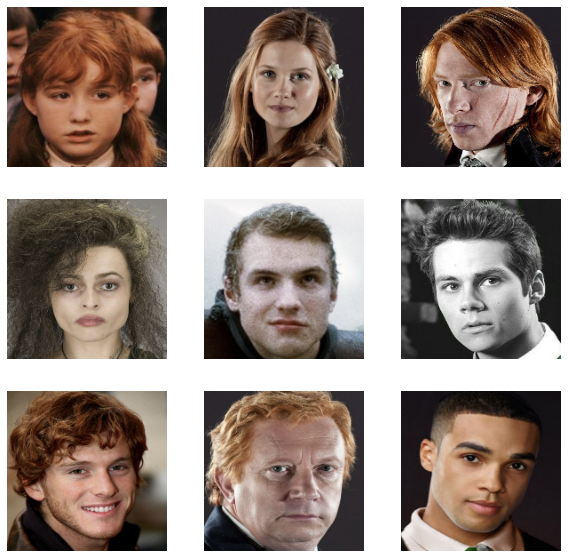

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
num_classes = 4

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape = (img_height, 
                                                               img_width,
                                                               3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [14]:
epochs=5
history = model.fit(
  x = train_ds,
  validation_data = val_ds,
  batch_size = 64,
  epochs = epochs
)

Epoch 1/5


2/2 [==============================] - 13s 2s/step - loss: 1.5904 - accuracy: 0.2222 - val_loss: 1.3834 - val_accuracy: 0.3750
Epoch 2/5
2/2 [==============================] - 6s 4s/step - loss: 1.4220 - accuracy: 0.2840 - val_loss: 1.3665 - val_accuracy: 0.5000
Epoch 3/5
2/2 [==============================] - 3s 3s/step - loss: 1.3850 - accuracy: 0.1358 - val_loss: 1.4144 - val_accuracy: 0.2500
Epoch 4/5
2/2 [==============================] - 4s 3s/step - loss: 1.3537 - accuracy: 0.3951 - val_loss: 1.4652 - val_accuracy: 0.2500
Epoch 5/5
2/2 [==============================] - 5s 854ms/step - loss: 1.3422 - accuracy: 0.3951 - val_loss: 1.4789 - val_accuracy: 0.2500


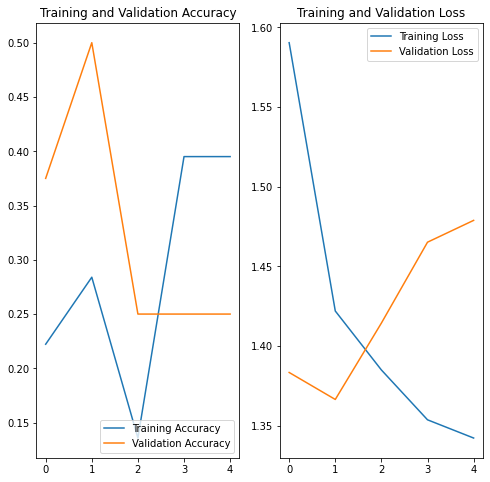

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
trail_url = "https://www3.nd.edu/~sberry5/data/sam_broom.jpg"
trail_url = tf.keras.utils.get_file('sam_broom', origin = trail_url)

img = keras.preprocessing.image.load_img(
    trail_url, target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 201ms/step
This image most likely belongs to Gryffindor with a 49.18 percent confidence.


In [18]:
from tensorflow.keras.preprocessing.image import load_img


In [20]:
from google.colab import drive
drive.mount('/content/drive')
img_path = '/content/drive/MyDrive/Test_classmate/Lance Yuan.png'

img = load_img(img_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 66ms/step
This image most likely belongs to Gryffindor with a 39.63 percent confidence.
